# Artificial Intelligence Course - Fall 1402
## Computer Assignment #2 - Reinforcement Learning
### Mohammad Ali Ghahari 810100201

# Table of Contents

- [Part 1: Value Iteration & Policy Iteration Algorithms](#1)
    - [Question 1:](#1-0)
    - [Question 2:](#1-1)
    - [Question 3:](#1-12)
    - [Question 4:](#1-2)
    - [Question 5:](#1-3)
        - [Value Iteration](#1-3-1)
        - [Policy Iteration](#1-3-2)
    - [Question 6:](#1-4)
        - [Value Iteration](#1-4-1)
        - [Policy Iteration](#1-4-2)
- [Part 2: Q-Learning Algorithm](#2)
    - [Question 7:](#2-0)
    - [Question 8:](#2-1)
    - [Question 9:](#2-2)
    - [Question 10:](#2-3)

In [113]:
# import
import numpy as np
import gymnasium as gym

<a name='1'></a>
## Part 1: Value Iteration & Policy Iteration Algorithms

In [114]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False,render_mode='rgb_array')
env.reset(seed=201)

(0, {'prob': 1})

<a name='1-0'></a>
### Question 1:

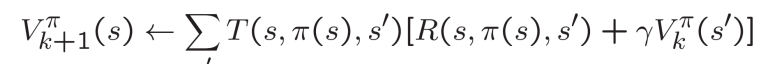
<p style="text-align:center;color:cyan" dir=rtl>
در این الگوریتم ما بهترین اکشن برای هر استیت را انتخاب می کنیم با توجه به فرمول بعد با توجه به جایزه ای که دریافت می کنیم استیت ولیو ها را آپدیت می کنیم.
این کار را آنقدر ادامه میدهیم تا تغییرات از حدی کمتر شود!
</p>

<a name='1-1'></a>
### Question 2:

In [115]:
class ValueIteration():
    def __init__(self, env, discount_factor, theta=1e-8):
        self.env = env
        self.discount_factor = discount_factor
        self.theta = theta
        self.reset()
        self.state_values =  np.ones((self.env.observation_space.n)) / self.env.action_space.n       
        self.q_values =  np.ones((self.env.observation_space.n, self.env.action_space.n)) / self.env.action_space.n       
        self.state_values[- 1] = 0
        self.q_values[- 1] =  np.zeros((self.env.action_space.n))

    def value_estimation(self):
        self.delta = np.inf
        counter = 0
        
        while(self.delta > self.theta):
            counter += 1
            self.delta = 0

            for state in range(self.env.observation_space.n):
                v = self.state_values[state]
                for action in range(self.env.action_space.n):
                    action_value = 0
                    for probability, next_state, reward, done in self.env.get_wrapper_attr('P')[state][action]:
                        action_value += probability*(reward+self.discount_factor*self.state_values[next_state])
                    self.q_values[state, action] = action_value
                self.state_values[state] = np.max(self.q_values[state,:])

                self.delta = np.max([self.delta, abs(v - self.state_values[state])])

                if (self.delta < self.theta):
                    break
        return counter

    def take_action(self, action):
        next_state, reward, done, _ ,_= self.env.step(action)
        return next_state, reward, done

    def get_optimal_policy(self, state):
        return np.argmax(self.q_values[state,:])

    def get_state_values(self):
        return self.state_values

    def get_q_values(self):
        return self.q_values

    def reset(self):
        return self.env.reset()[0]

<a name='1-12'></a>
### Question 3:

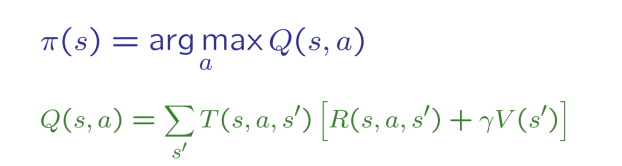
<p style="text-align:center;color:cyan" dir=rtl>
الگوریتم این گونه است که ما ابتدا یک پالیسی انتخاب می کنیم و بعد بر اساس آن ولیو استیت ها را آپدیت می کنیم تا وقتی که آن ها همگرا بشوند حالا با استفاده از ولیو استیت ها پالیسی را آپدیت می کنیم بدین گونه که به سمت استیتی میرویم که ماکسیمم  q_value در آن قرار دارد، حالا کل این کار را اینقدر انجام می دهیم تا خود پالیسی همگرا شده و تغیر نکند.</p>

<a name='1-2'></a>
### Question 4:

In [116]:
class PolicyIteration():
    def __init__(self, env, discount_factor, theta=1e-8):
        self.env = env
        self.discount_factor = discount_factor
        self.theta = theta
        self.reset()
        self.state_values = np.ones((self.env.observation_space.n)) / self.env.action_space.n
        self.q_values = np.ones((self.env.observation_space.n, self.env.action_space.n)) / self.env.action_space.n
        self.state_values[self.env.observation_space.n - 1] = 0
        self.q_values[self.env.observation_space.n - 1] = np.zeros((self.env.action_space.n))
        self.policy = np.random.randint(self.env.action_space.n, size=self.env.observation_space.n) 
        self.policy_stable = False

    def policy_evaluation(self):
        self.delta = np.inf
        counter = 0
        while(self.delta >= self.theta):
            counter += 1
            self.delta = 0

            for state in range(self.env.observation_space.n):

                v = self.state_values[state]

                new_state_value = 0
                for probability, next_state, reward, done in self.env.get_wrapper_attr('P')[state][self.policy[state]]:
                    new_state_value += probability * (reward + self.discount_factor * self.state_values[next_state])
                self.state_values[state] = new_state_value

                self.delta = np.max([self.delta, abs(v - self.state_values[state])])
        return counter

    def policy_improvement(self):
        self.policy_stable = True

        for state in range(self.env.observation_space.n):
            old_policy = self.policy[state]

            for action in range(self.env.action_space.n):

                action_value = 0
                for probability, next_state, reward, done in self.env.get_wrapper_attr('P')[state][action]:
                    action_value += probability * (reward + self.discount_factor * self.state_values[next_state])
                self.q_values[state, action] = action_value

            self.policy[state] = np.argmax(self.q_values[state,:])

            if old_policy != self.policy[state]:
                self.policy_stable = False

    def policy_estimation(self):
        self.policy_stable = False
        counter = 0
        while not self.policy_stable:
            counter += self.policy_evaluation()
            self.policy_improvement()
        return counter

    def take_action(self, action):
        next_state, reward, done, _ ,_= self.env.step(action)
        return next_state, reward, done

    def get_optimal_policy(self, state):
        return self.policy[state]

    def get_state_values(self):
        return self.state_values

    def get_q_values(self):
        return self.q_values

    def reset(self):
        initial_state,_ = self.env.reset()
        return initial_state

<a name='1-3'></a>
### Question 5:

In [117]:
import pygame , time

# Colours
GREEN = (0,255,0) 
RED = (255, 0, 0)
BLUE = (0, 0, 255)
BLACK = (0,0,0)
WHITE = (255,255,255)
UP = 3
DOWN = 1
LEFT = 0
RIGHT = 2

def lerp(color1:tuple,color2:tuple,val:float)->tuple:
    dif= (color2[0]-color1[0],color2[1]-color1[1],color2[2]-color1[2])
    return (color1[0]+dif[0]*val,color1[1]+dif[1]*val,color1[2]+dif[2]*val)

class Show:
    width=100
    height=100
    margin = 6
    
    def __init__(self,title:str,blocks:tuple,max_val:int) -> None:
        pygame.init()
        self.max_val=max_val
        self.blocks=blocks
        self.size=[blocks[0]*(self.width+self.margin)+self.margin,blocks[0]*(self.height+self.margin)+self.margin]
        self.screen=pygame.display.set_mode(self.size)
        self.screen.fill(BLACK)
        pygame.display.set_caption(title)
        self.done=False
        self.font=pygame.font.SysFont('arial', 10)
        self.font2=pygame.font.SysFont('arial', 20)
        
    def Run(self,q_func,p_func):
        q_val = list(q_func())
        for row in range(self.blocks[0]):
            for col in range(self.blocks[1]):
                avarage = sum(q_val[self.blocks[0]*row+col])/self.max_val
                if(avarage>=0):
                    color = lerp(WHITE,GREEN,min(1,avarage))
                else:
                    color = lerp(WHITE,RED,min(1,-avarage))
                x=(self.margin+self.width)*col+self.margin
                y=(self.margin+self.height)*row+self.margin
                rect=[x,y,self.width,self.height]
                pygame.draw.rect(self.screen,color,rect)
                text=self.font2.render(f'{max(q_val[self.blocks[0]*row+col]):.3f}', True, RED)
                rect=text.get_rect()
                rect[0] = x+self.width/2-rect[2]/2
                rect[1] = y+self.height/2-rect[3]/2
                self.screen.blit(text, rect)
                for act in range(4):                    
                    text=self.font.render(f'{q_val[self.blocks[0]*row+col][act]:.2f}', True, BLUE if act == p_func(self.blocks[0]*row+col) else BLACK)
                    rect=text.get_rect()
                    if act == UP or act == DOWN:
                        rect[0] = x+self.width/2-rect[2]/2
                    else:
                        rect[0] = x if act == LEFT else (x+self.width-rect[2])
                    if act == LEFT or act == RIGHT: 
                        rect[1] = y+self.height/2-rect[3]/2
                    else:
                        rect[1] = y if act == UP else (y+self.height-rect[3])
                    self.screen.blit(text, rect)
        pygame.display.flip()
        while self.done==False:
            for event in pygame.event.get():
                if event.type == pygame.QUIT: 
                    self.done=True 
        pygame.quit ()

<a name='1-3-1'></a>
#### Value Iteration:

In [118]:
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

test=ValueIteration(env,.9)
test.reset()
timer=time.time()
episodes = test.value_estimation()
timer=time.time()-timer
print("total time : " + str(timer))
print("total episodes : " + str(episodes))

Show("Value Iteration",(4,4),1).Run(test.get_q_values,test.get_optimal_policy)


state = test.reset()
for i in range(50):    
    plt.imshow(env.render())
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())    
    state, _, done = test.take_action(test.get_optimal_policy(state))
    time.sleep(.5)
    if done:
        break
plt.imshow(env.render())
ipythondisplay.clear_output(wait=True)
ipythondisplay.display(plt.gcf())  
ipythondisplay.clear_output(wait=True)
    

total time : 0.014999866485595703
total episodes : 7


<a name='1-3-2'></a>
#### Policy Iteration:

In [119]:
test=PolicyIteration(env,.9)
test.reset()
timer=time.time()
episodes = test.policy_estimation()
timer=time.time()-timer
print("total time : " + str(timer))
print("total episodes : " + str(episodes))

Show("Policy Iteration",(4,4),1).Run(test.get_q_values,test.get_optimal_policy)

state = test.reset()
for i in range(50):    
    plt.imshow(env.render())
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())    
    state, _, done = test.take_action(test.get_optimal_policy(state))
    time.sleep(.5)
    if done:
        break
plt.imshow(env.render())
ipythondisplay.clear_output(wait=True)
ipythondisplay.display(plt.gcf())  
ipythondisplay.clear_output(wait=True)

total time : 0.1029970645904541
total episodes : 153


<a name='1-4'></a>
### Question 6:

<p style="text-align:center;color:cyan" dir=rtl>
میبینیم که مقدار استیت ها مثل هم هستند به جز برای دریاچه که در پالیسی ایتریشن مقدار 0 در نظر گرفته شده اما این مقدار برای ولیو ایتریشن 0.133  می باشد. دلیل آن این است که در پالیسی فقط آن جا هایی که میرود را حساب میکند که به طبع دریاچه ها را حساب نمیکند ولی در ولیو روی همه حلقه زده و حساب میکند!<br>
پالیسی نهایی نیز برای هر دو یکسان است.<br>
زمان ولیو ایتریشن نیز کمتر است که دلیل آن نیز این است چون یک اینکه تعداد اکشن ها کم بوده و همچنین فضای مساله محدود بوده ولیو ایتریشن زودتر میرسد!</p>

<a name='1-4-1'></a>
#### Value Iteration:

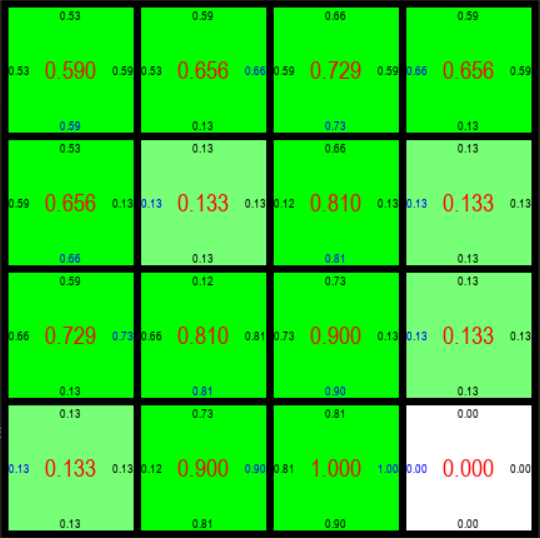

<a name='1-4-2'></a>
#### Policy Iteration:

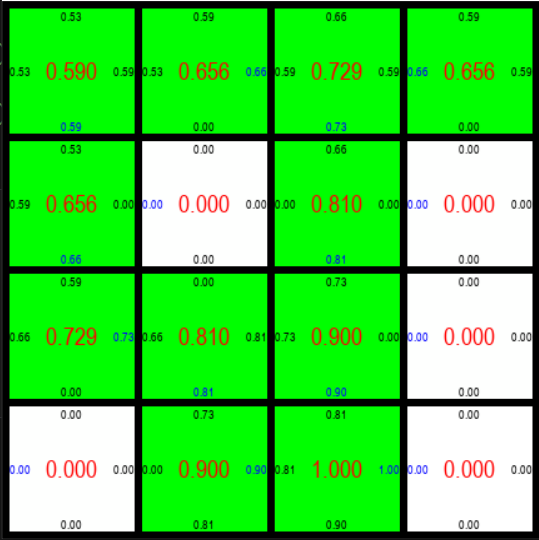

<a name='2'></a>
## Part 2: Q-Learning Algorithm

<a name='2-0'></a>
### Question 7:

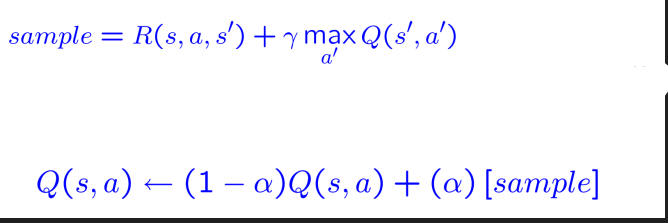
<p style="text-align:center;color:cyan" dir=rtl>
در این روش انتخاب اکشن ما به این صورت است که در ابتدا اپسیلون را تعریف می کنیم بعد به صورت رندوم اگر مقداری کمتر از آن شد اکشن را به صورت رندوم انتخاب می کنیم تا جا های جدید را کشف کنیم که شاید جا های بهتری هم وجود داشته باشد در غیر این صورت بهترین اکشن را انتخاب می کنیم که معقول است!<br>
که به مرور این اپسیلون را کاهش داده تا به مرور کار های عجیب و غریب کمتر بکنیم چون ما تا آخر عمر وقت نداریم تا ایجنت ما کشفیات انجام دهد.
<br>
نرخ یاد گیری نیز به این معنی است که ما چه قدر به اعداد به دست آمده اهمیت میدهیم که هرچه کمتر باشد زود تر همگرا میشویم اما با این کار باعش میشویم کمتر جایزه بگیریم چون کمتر به کشفیات جدید اهمیت میدهیم و فرصت را از آن ها میگیریم با زود تر به همگرایی رسیدن!
<br>
حالا بعد از هر اکشن با توجه به فرمول و ریوارد و نرخ یادگیری مقدار استیت را آپدیت می کنیم
همچنین با توجه به مقدار استیت مقصد آپدیت را انجام میدهیم. </p>

<a name='2-1'></a>
### Question 8:

In [120]:
# hyperparameters
REPS = 20
EPISODES = 2000
EPSILON = 0.1
LEARNING_RATE = 0.1
DISCOUNT = 0.9
STUDENT_NUM = 201

In [121]:
import random

class QLearningAgent():
    def __init__(self, env, epsilon, learning_rate, discount_factor, seed):
      self.env = env
      self.epsilon = epsilon
      self.learning_rate = learning_rate
      self.olr = learning_rate
      self.discount_factor = discount_factor
      self.q_table = np.zeros((env.observation_space.n, env.action_space.n))
      self.seed = seed

    def choose_action(self, state):
      if(random.random() < self.epsilon):
        return random.randint(0,self.env.action_space.n - 1)
      return self.get_optimal_policy(state)

    def update_q_table(self, state, action, nextState, reward):
      sample = reward + self.discount_factor * max([self.q_table[nextState][i] for i in range(self.env.action_space.n)])
      self.q_table[state][action] = (1 - self.learning_rate) * self.q_table[state][action] + self.learning_rate * sample

    def set_qtable(self, qtable):
      self.q_table = qtable

    def decay_epsilon(self, _):
      self.epsilon -= self.epsilon / EPISODES

    def decrease_learning_rate(self, _):
      self.learning_rate -= self.learning_rate / EPISODES

    def take_action(self, action):
      next_state, reward, done, _ , _ = self.env.step(action)
      return next_state, reward, done

    def get_optimal_policy(self, state):
      return np.argmax(self.q_table[state])

    def get_q_values(self):
      return self.q_table

    def reset(self):
      self.learning_rate = self.olr
      return self.env.reset(seed=self.seed)[0]
    
    def render(self):
      img = self.env.render()
      plt.imshow(img)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())
      time.sleep(0.1)

In [122]:
x_list = [i+1 for i in range(EPISODES)]
rewards = [0 for _ in range(EPISODES)]
q_tables = []
agent_rew = []
timers=[0 for _ in range(EPISODES)]
agent = ...
for rep in range(REPS):
    agent = QLearningAgent(gym.make('Taxi-v3',render_mode="rgb_array") , EPSILON , LEARNING_RATE ,DISCOUNT , STUDENT_NUM)
    all_rew = 0
    for episode in range(EPISODES):        
        state = agent.reset()
        sum_reward = 0
        done = False    
        timer=time.time()    
        while not done:            
            action = agent.choose_action(state)
            next_state , reward , done  = agent.take_action(action)
            sum_reward += reward
            all_rew += reward
            agent.update_q_table(state , action , next_state , reward)
            state = next_state
        
        agent.decay_epsilon(episode)
        
        rewards[episode] += sum_reward
        timers[episode] += time.time()-timer
    
    agent_rew.append(all_rew)
    q_tables.append(agent.get_q_values())
    print(("" if rep == 0 else ("\b" if rep<10 else "\b\b"))+str(rep+1),end="")
rewards = [i/REPS for i in rewards]
timers = [i/REPS for i in timers]
print("")

rewards2 = [0 for _ in range(EPISODES)]
timers2 = [0 for _ in range(EPISODES)]
agent2 = ...
for rep in range(REPS):
    agent2 = QLearningAgent(gym.make('Taxi-v3',render_mode="rgb_array") , EPSILON , LEARNING_RATE ,DISCOUNT , STUDENT_NUM)
    for episode in range(EPISODES):        
        state = agent2.reset()
        sum_reward = 0
        done = False    
        timer=time.time()    
        while not done:            
            action = agent2.choose_action(state)
            next_state , reward , done  = agent2.take_action(action)
            sum_reward += reward
            agent2.update_q_table(state , action , next_state , reward)
            state = next_state
        
        agent.decrease_learning_rate(episode)
        agent2.decay_epsilon(episode)
        
        rewards2[episode] += sum_reward
        timers2[episode] += time.time()-timer
        
    print(("" if rep == 0 else ("\b" if rep<10 else "\b\b"))+str(rep+1),end="")
rewards2 = [i/REPS for i in rewards2]
timers2 = [i/REPS for i in timers2]
print("")
        

20
20


<a name='2-2'></a>
### Question 9:

<p style="text-align:center;color:cyan" dir=rtl>
با قرار دادن decrease_learning_rate اوضاع بدتر شد! اما از نظر زمان خیلی نزدیک هم هستند ولی کمی با DLR اوضاع بهتر است! چون به مرور کمتر میخواهد یاد بگیرد و این باعث میود که کمتر دچار تغییر شود و زود تر به همگرایی برسد.<br>
برای decrease کردن هم اینگونه عمل کردم که به نسبت مقدار فعلی متغیر مورد نطر به کل اپیزود ها با صرف نظر اپیزود فعلی یک مقداری را کم میکنم! </p>

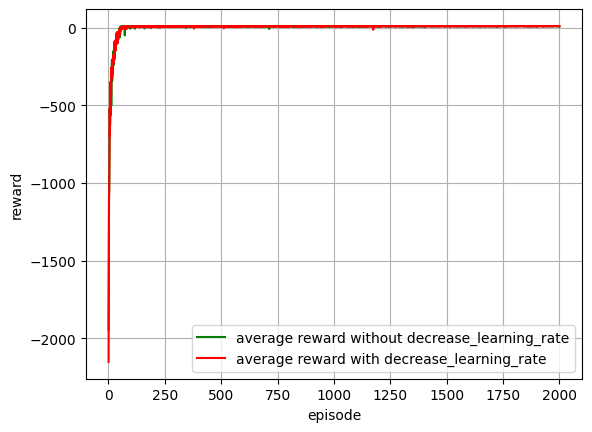

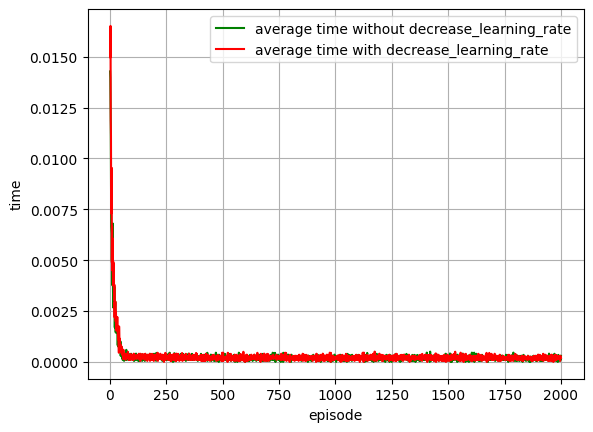

avarage of reward in all episode with DLR : 0.48164999999999975
avarage of reward in all episode without DLR : 0.5198500000000017
avarage of time in all episode with DLR : 0.00029907603263855034
avarage of time in all episode without DLR : 0.0002719850838184355


In [123]:
plt.plot(x_list , rewards  , color = 'g'  , label='average reward without decrease_learning_rate')
plt.plot(x_list , rewards2  , color = 'r'  , label='average reward with decrease_learning_rate')

plt.xlabel('episode')
plt.ylabel('reward')
plt.legend()
plt.grid()
plt.show()

plt.plot(x_list , timers  , color = 'g'  , label='average time without decrease_learning_rate')
plt.plot(x_list , timers2  , color = 'r'  , label='average time with decrease_learning_rate')

plt.xlabel('episode')
plt.ylabel('time')
plt.legend()
plt.grid()
plt.show()

print("avarage of reward in all episode with DLR : " + str(sum(rewards2)/EPISODES))
print("avarage of reward in all episode without DLR : " + str(sum(rewards)/EPISODES))
print("avarage of time in all episode with DLR : " + str(sum(timers2)/EPISODES))
print("avarage of time in all episode without DLR : " + str(sum(timers)/EPISODES))

<a name='2-3'></a>
### Question 10:

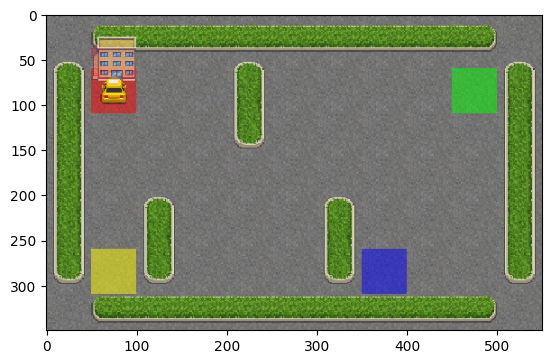

In [124]:
agent.set_qtable(q_tables[np.argmax(agent_rew)])
state = agent.reset()
done = False        
while not done:
    state , _ , done  = agent.take_action(agent.get_optimal_policy(state))
    agent.render()
ipythondisplay.clear_output(wait=True)